In [1]:
# Import necessary libraries

import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import urllib
import numpy as np
import json
import gensim
import gensim.downloader
import re 

In [2]:
# Download word vectorizer
vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [3]:
# Download data
def get_response(url):
    operUrl = urllib.request.urlopen(url)
    if(operUrl.getcode()==200):
        data = operUrl.read()
    else:
        print("Error receiving data", operUrl.getcode())
    return data

data = get_response('https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_full.json')

In [4]:
# Load and combine data into train, val, and test sets
json_data = json.loads(data)
val = json_data['val']
oos_val = json_data['oos_val']
test = json_data['test']
oos_test = json_data['oos_test']
train = json_data['train']
oos_train = json_data['oos_train']


for i in oos_train:
    train.append(i) 

for i in oos_val:
    val.append(i) 

for i in oos_test:
    test.append(i) 

In [5]:
### Strip data of symbols and convert to lists of strings    
# Create regex pattern
pattern = re.compile('[^\w\s]')

# Define function to apply regex pattern over each dataset
def string_separation(data):
    return [pattern.sub('', data[i][0]).split(" ") \
     for i, j in enumerate(data)]

# Apply function to each dataset
train_separated_values = string_separation(train)
val_separated_values = string_separation(val)
test_separated_values = string_separation(test)

In [6]:
### vectorize each value using word2vec

# Create function that checks if a string can be vectorized against the vectorizer
# If it can, vectorize it, otherwise return a 0.0 array of equal size
def get_vector(string):
    try: 
        value = vectors.get_vector(string)
        return value
    except:
        return np.array([0.0] * 50)
    
# Create a function that applies the get_vector function across a list of values
def convert_to_vectors(series):
    new_series = []

    for i in series:
        if i == '':
            pass
        else:
            new_series.append(get_vector(i))
            
    return new_series

# Define a function that applies convert_to_vectors across an entire dataset
def vectorize_samples(data):
    return [convert_to_vectors(data[i]) for i, j in enumerate(data)]

# Vectorize each dataset
train_X_arrays = vectorize_samples(train_separated_values)
val_X_arrays = vectorize_samples(val_separated_values)
test_X_arrays = vectorize_samples(test_separated_values)

In [7]:
# Since values are being assigned to Tensors establish the storage location by checking for GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [8]:
# Establish padding length (Could have been as low as 30 given data set 50 was chosen to increase usability)
pad_length = 28

# Create an empty array to be used for padding values
pad_value = np.array([0.0] * 50, dtype=np.float32)

# Define function that takes a list, pad_length, and pad_value to create a new array of values with 0 padded values up to the pad_length
def adjust_padding(some_list, pad_length=pad_length, pad_value=pad_value):
    some_list = list(some_list)
    while len(some_list) < pad_length:
        some_list.append(pad_value)
    return np.array(some_list)

# Apply the function over each dataset
train_padded      = [adjust_padding(i) for i in train_X_arrays]
val_padded        = [adjust_padding(val_X_arrays[i]) for i, j in enumerate(val_X_arrays)]
test_padded       = [adjust_padding(test_X_arrays[i]) for i, j in enumerate(test_X_arrays)]

# Convert arrays to tensors to feed model

train_set         = torch.tensor(train_padded).reshape((15100,28,50)).float().to(device)
val_set           = torch.tensor(val_padded).reshape((3100,28,50)).float().to(device)
# test_set          = torch.tensor(test_padded).reshape((5500,28,50)).float().to(device)

# Create tensors of answers

train_answer      = [j[1] for i, j in enumerate(train)]
val_answer        = [j[1] for i, j in enumerate(val)]
test_answer       = [j[1] for i, j in enumerate(test)]

In [9]:
### Create an index to train against

# Create dictionary map of each unique answer type
sorted_list = list(set([train[i][1] for i, j in enumerate(train)]))
sorted_list.sort()
chosen_dict = {j: i for i, j in enumerate(sorted_list)}

# Use dictionary to consistently label answer data
for item in chosen_dict.keys():
    for i, j in enumerate(train_answer):
        if item == j:
            train_answer[i] = chosen_dict[item]
    for i, j in enumerate(val_answer):
        if item == j:
            val_answer[i] = chosen_dict[item]
    for i, j in enumerate(test_answer):
        if item == j:
            test_answer[i] = chosen_dict[item]

# Convert labeled data into tensors
train_answers = torch.tensor(train_answer).to(device)
val_answers = torch.tensor(val_answer).to(device)
# test_answers = torch.tensor(test_answer).to(device)

In [10]:
class ClassifierLSTM(nn.Module):

    def __init__(self):

        super(ClassifierLSTM, self).__init__()
        
        self.lstm = nn.LSTM(batch_first=True, input_size=50, hidden_size=256, bidirectional=True)


        self.linear1 = nn.Linear(256, 256)
        self.linear1_2 = nn.Linear(256, 256)
        self.probs_pre = nn.Linear(512, 151) # 151 output classes
        self.probabilities = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(.25)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)

        hidden1 = hidden[0]
        hidden2 = hidden[1]
        # Take hidden layer as output. 
        x = F.elu(self.dropout(self.linear1(hidden1)))
        x_2 = F.elu(self.dropout(self.linear1_2(hidden2)))
        x = torch.cat((x, x_2), 1)
        x = self.probabilities(self.probs_pre(x))
        
        return x

In [11]:
model = ClassifierLSTM().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)


avg_loss_list = []
val_loss_list = []

In [12]:
BATCH_SIZE = 512

for epoch in range(25000):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()
    loss_list = []
    # forward + backward + optimize
    for i in range(math.ceil(train_set.shape[0] / BATCH_SIZE)):
        
        outputs = model(train_set[i*BATCH_SIZE:(1+i)*BATCH_SIZE])
        loss = criterion(outputs, train_answers[i*BATCH_SIZE:(1+i)*BATCH_SIZE])

        loss_list.append(float(str(loss).split("(")[1].split(",")[0]))

        loss.backward()
    
    optimizer.step()
    
    avg_loss_list.append(np.average(loss_list))
    val_outputs = model(val_set)
    val_loss = criterion(val_outputs, val_answers)
    
    val_loss_list.append(float(str(val_loss).split("(")[1].split(",")[0]))
    
    # print statistics
    if epoch % 50 == 0:
        print("Loss:     " + str(avg_loss_list[-1]))
        print("Val Loss: " + str(val_loss).split("(")[1].split(",")[0])
        print(str(epoch/250) + "% done")

print('Finished Training')

Loss:     5.017273333333335
Val Loss: 5.0172
0.0% done
Loss:     4.984243333333334
Val Loss: 4.9861
0.2% done
Loss:     4.9507433333333335
Val Loss: 4.9588
0.4% done
Loss:     4.8729233333333335
Val Loss: 4.8951
0.6% done
Loss:     4.80422
Val Loss: 4.8433
0.8% done
Loss:     4.7937233333333324
Val Loss: 4.8357
1.0% done
Loss:     4.790386666666666
Val Loss: 4.8338
1.2% done
Loss:     4.786730000000001
Val Loss: 4.8317
1.4% done
Loss:     4.77861
Val Loss: 4.8230
1.6% done
Loss:     4.769313333333333
Val Loss: 4.8126
1.8% done
Loss:     4.755893333333334
Val Loss: 4.8021
2.0% done
Loss:     4.754903333333334
Val Loss: 4.7993
2.2% done
Loss:     4.754256666666667
Val Loss: 4.7981
2.4% done
Loss:     4.735033333333335
Val Loss: 4.7810
2.6% done
Loss:     4.704486666666667
Val Loss: 4.7530
2.8% done
Loss:     4.690203333333334
Val Loss: 4.7437
3.0% done
Loss:     4.687209999999999
Val Loss: 4.7396
3.2% done
Loss:     4.6701533333333325
Val Loss: 4.7282
3.4% done
Loss:     4.65326666666666

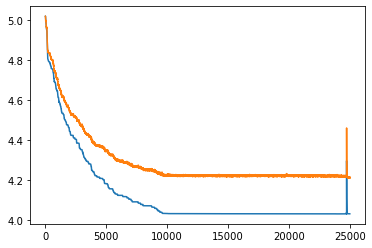

In [13]:
plt.plot(avg_loss_list)
plt.plot(val_loss_list)

In [14]:
outputs = model(val_set)

maxes = np.argmax(outputs.to('cpu').detach().numpy(), axis = 1)
correct_guesses = [maxes[i] == val_answer[i] for i in range(len(maxes))]

print("Percent correct (Accuracy): " + str(correct_guesses.count(True)/len(correct_guesses)))

torch.save(model, '.\\models\\LSTM_wide')
torch.save({'epoch': 25000, 'model': model, 'optimizer': optimizer}, '.\\models\\LSTM_wide_checkpoint')

Percent correct (Accuracy): 0.8209677419354838
